## **Fine Tuning BERT (Biderectional Encoder Representation from Transformers) for Sentiment Analysis Task in Indonesian Language**

#### **Steps for fine tuning BERT Model**

*   Install Library
*   Load Dataset
*   Load BERT Model and Tokenizer
*   Tokenize Dataset
*   Training & Evaluation
*   Push to Transformers Hub
*   Downsizing with ONNXRuntime
*   Saving



## **Install Library**

In [2]:
# For hiding output cell
%%capture

!pip install transformers
!pip install tokenizers
!pip install datasets
!pip install torch
!pip install onnxruntime
!pip install onnx
!sudo apt-get install git-lfs

## **Load Dataset**

In [15]:
from datasets import load_dataset

sentiment_data = load_dataset("indonlu", "smsa")
sentiment_data

Generating train split:   0%|          | 0/11000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset indonlu downloaded and prepared to /root/.cache/huggingface/datasets/indonlu/smsa/1.0.0/0a83b181cd831cd5d9c15ffe39f3be76af23407eba2c902bccca53fa905d68af. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [37]:
sentiment_data['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 11000
})

In [38]:
sentiment_data['train'].features

{'label': ClassLabel(num_classes=3, names=['positive', 'neutral', 'negative'], id=None),
 'text': Value(dtype='string', id=None)}

In [39]:
sentiment_data['train'][3]

{'label': 0,
 'text': 'betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !'}

In [40]:
import pandas as pd

sentiment_data.set_format(type="pandas") 
df = sentiment_data["train"][:] 
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0
1,mohon ulama lurus dan k212 mmbri hujjah partai...,1
2,lokasi strategis di jalan sumatera bandung . t...,0
3,betapa bahagia nya diri ini saat unboxing pake...,0
4,duh . jadi mahasiswa jangan sombong dong . kas...,2


In [41]:
def label_int2str(row): 
  return sentiment_data["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str) 
df.head()

,text,label,label_name
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,1,neutral
2,lokasi strategis di jalan sumatera bandung . t...,0,positive
3,betapa bahagia nya diri ini saat unboxing pake...,0,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,2,negative


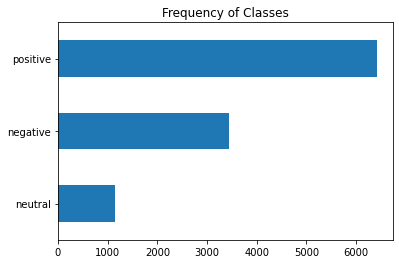

In [42]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh() 
plt.title("Frequency of Classes") 
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


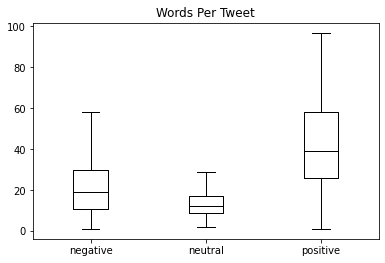

In [43]:
df["Words Per Tweet"] = df["text"].str.split().apply(len) 
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("") 
plt.xlabel("") 
plt.show()

In [44]:
sentiment_data.reset_format()

## **Load BERT Tokenizer & Model**

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

ckpt = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(ckpt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(ckpt, num_labels=3).to(device)


In [46]:
text = sentiment_data['train'][3]['text']
text

'betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !'

In [47]:
encoded_text = tokenizer(text) 
print(encoded_text)

{'input_ids': [2, 5108, 4771, 1107, 745, 92, 305, 78, 9269, 55, 1998, 41, 963, 1107, 1305, 30457, 4356, 1320, 423, 30457, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [48]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [49]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids) 
print(tokens)

['[CLS]', 'betapa', 'bahagia', 'nya', 'diri', 'ini', 'saat', 'un', '##box', '##ing', 'paket', 'dan', 'barang', 'nya', 'bagus', '!', 'menetapkan', 'beli', 'lagi', '!', '[SEP]']


In [50]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus! menetapkan beli lagi! [SEP]


In [51]:
tokenizer.vocab_size

30521

In [52]:
print(tokenizer.get_vocab())

{'dibagikan': 12088, 'membaik': 12391, 'indofood': 19620, 'karsin': 24923, 'external': 22493, '##penyebab': 27675, 'menjauh': 7434, 'trader': 11104, 'ishak': 25124, '##ekam': 14720, 'sebenar': 20162, 'rong': 8301, 'diamkan': 15741, 'ayat': 1862, 'superman': 28085, '##semoga': 15932, '##‘': 30394, 'ramb': 13378, '##adukan': 10150, '##eb': 77, 'nec': 27518, '##ae': 27349, '##pihak': 10997, 'statistika': 23972, 'tubuhmu': 25039, 'kapanlagi': 21959, 'mengunggah': 21164, 'sipil': 4318, '##bondong': 28799, 'mengabdi': 17538, '##fiq': 18203, '##ukis': 7982, '76': 10036, 'martabat': 14834, '##233': 27104, 'fus': 26795, 'research': 11366, 'www': 3940, '##mong': 28167, 'alamin': 29444, 'jendral': 14307, '##obus': 24057, '##ha': 1568, '##angin': 16135, 'sudah': 259, 'lanjut': 1727, '##engineer': 23860, '##arilah': 24600, 'pikir': 3279, 'melemp': 10659, 'wedding': 14147, '##ido': 10596, 'tentara': 5085, 'torsi': 20335, 'jobs': 7298, '##onom': 994, 'caranya': 3621, 'flek': 15692, '##uncurkan': 5491

## **Tokenized Dataset**

In [53]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [54]:
tokenized_sentiment = sentiment_data.map(preprocess_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/indonlu/smsa/1.0.0/0a83b181cd831cd5d9c15ffe39f3be76af23407eba2c902bccca53fa905d68af/cache-3054adf1341b48ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/indonlu/smsa/1.0.0/0a83b181cd831cd5d9c15ffe39f3be76af23407eba2c902bccca53fa905d68af/cache-74765ad8cbfbca91.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

## **Training & Evaluation**

### Create Evaluation Score

In [55]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred): 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    f1 = f1_score(labels, preds, average="weighted") 
    acc = accuracy_score(labels, preds) 
    return {"accuracy": acc, "f1": f1}

### Login to Hugging Face Account

In [56]:
from huggingface_hub import notebook_login 
notebook_login()

### Training The Model

In [57]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="./indobert-classification", 
                                  num_train_epochs=5,  
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=16, 
                                  per_device_eval_batch_size=16, 
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  log_level="error",
                                  logging_dir="./logs", 
                                  push_to_hub=True,
                                  logging_steps=len(tokenized_sentiment["train"]) // 16,)



In [58]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["validation"],
    tokenizer=tokenizer,
)

trainer.train()

/content/./indobert-classification is already a clone of https://huggingface.co/afbudiman/indobert-classification. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.245800,0.222948,0.932540,0.932253
2,0.125800,0.233157,0.937302,0.936854
3,0.059000,0.338918,0.936508,0.936494
4,0.026800,0.341169,0.942063,0.941721
5,0.009700,0.370685,0.939683,0.939306


Several commits (3) will be pushed upstream.


TrainOutput(global_step=3440, training_loss=0.09329970067002821, metrics={'train_runtime': 2651.9216, 'train_samples_per_second': 20.74, 'train_steps_per_second': 1.297, 'total_flos': 3578235591274848.0, 'train_loss': 0.09329970067002821, 'epoch': 5.0})

In [59]:
preds_output = trainer.predict(tokenized_sentiment["validation"])
preds_output.metrics

{'test_accuracy': 0.9396825396825397,
 'test_f1': 0.9393057427148881,
 'test_loss': 0.3706847131252289,
 'test_runtime': 15.2283,
 'test_samples_per_second': 82.741,
 'test_steps_per_second': 5.188}

## **Push The Trained Model to HuggingFace Hub**

In [60]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (4) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/475M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/afbudiman/indobert-classification
   c75f2ac..8a0ba73  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/afbudiman/indobert-classification
   8a0ba73..9847311  main -> main



'https://huggingface.co/afbudiman/indobert-classification/commit/8a0ba73b550f3c8542a6c99b0d3d9790af493efa'

## **Try The Model using Pipeline**

In [61]:
from transformers import pipeline

model_id = "afbudiman/indobert-classification" 
classifier = pipeline("text-classification", model=model_id)


Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/693k [00:00<?, ?B/s]

In [62]:
custom_tweet = "gue gak suka nonton film horror" 
preds = classifier(custom_tweet, return_all_scores=False)
preds[0]

{'label': 'LABEL_2', 'score': 0.999861478805542}

## **Saving The Model**

In [63]:
tokenizer.save_pretrained('results/indobert/')
model.save_pretrained('results/indobert/')

## **Downsizing The Model with OnnxRuntime**

### Convert Model to Onnx Format

In [3]:
from transformers.convert_graph_to_onnx import convert
from pathlib import Path
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_ckpt = "afbudiman/indobert-classification"
onnx_model_path = Path("onnx/model.onnx")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/693k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

ONNX opset version set to: 12
Loading pipeline (model: afbudiman/indobert-classification, tokenizer: PreTrainedTokenizerFast(name_or_path='afbudiman/indobert-classification', vocab_size=30521, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))


/usr/local/lib/python3.7/dist-packages/transformers/convert_graph_to_onnx.py:380: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  FutureWarning,


Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Creating folder onnx
Using framework PyTorch: 1.11.0+cu113
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


### Create Onnx Runtime Provider

In [4]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [5]:
onnx_model = create_model_for_provider(onnx_model_path)

### Quantize The Converted Model

In [6]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[MatMul_68]
Ignore MatMul due to non constant B: /[MatMul_73]
Ignore MatMul due to non constant B: /[MatMul_162]
Ignore MatMul due to non constant B: /[MatMul_167]
Ignore MatMul due to non constant B: /[MatMul_256]
Ignore MatMul due to non constant B: /[MatMul_261]
Ignore MatMul due to non constant B: /[MatMul_350]
Ignore MatMul due to non constant B: /[MatMul_355]
Ignore MatMul due to non constant B: /[MatMul_444]
Ignore MatMul due to non constant B: /[MatMul_449]
Ignore MatMul due to non constant B: /[MatMul_538]
Ignore MatMul due to non constant B: /[MatMul_543]
Ignore MatMul due to non constant B: /[MatMul_632]
Ignore MatMul due to non constant B: /[MatMul_637]
Ignore MatMul due to non constant B: /[MatMul_726]
Ignore MatMul due to non constant B: /[MatMul_731]
Ignore MatMul due to non constant B: /[MatMul_820]
Ignore MatMul due to non constant B: /[MatMul_825]
Ignore MatMul due to non constant B: /[MatMul_914]
Ignore MatMul due to non constant

In [7]:
onnx_quantized_model = create_model_for_provider(model_output)

### Create New Pipeline for Onnx Model

In [8]:
from scipy.special import softmax
import numpy as np

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        sentiments = {0: "POSITIVE", 1: "NEUTRAL", 2: "NEGATIVE"}
        return sentiments[pred_idx], probs[pred_idx]


### Try The Onnx Model

In [9]:
pipe = OnnxPipeline(onnx_model, tokenizer)

In [10]:
query = """jelek sekali filmnya, saya tidak akan pernah nonton lagi"""
pipe(query)[0]

'NEGATIVE'

## **That's it** 💯